*Goal: Use machine learning to create a model that predicts which passengers survived the Titanic shipwreck.
Evaluation metric: accuracy.*

<h1 id="tocheading">Table of Contents</h1>
<div id="toc" ></div>

In [1]:
%%javascript
$.getScript('https://kmahelona.github.io/ipython_notebook_goodies/ipython_notebook_toc.js')

<IPython.core.display.Javascript object>

In [2]:
# Import libraries

import numpy as np 
import pandas as pd
import sklearn
from scipy import stats
from scipy.stats import norm, skew
import time

from sklearn.metrics import precision_score, recall_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import mean_squared_error
from sklearn import datasets, metrics

import lightgbm 
from xgboost import XGBClassifier
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import AdaBoostClassifier

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split

from sklearn.pipeline import make_pipeline
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder
from sklearn.compose import ColumnTransformer

# Plot pretty figures
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')
#plt.style.use('fivethirtyeight')


import IPython
from IPython import display #pretty printing of dataframes in Jupyter notebook

# Ignore useless warnings
import warnings
warnings.filterwarnings(action='ignore')

# Get the Data

In [5]:
# Read the csv train and test file
train = pd.read_csv('titanic_data/train.csv')
test = pd.read_csv('titanic_data/test.csv')

train.shape , test.shape

((891, 12), (418, 11))

# EDA

Study each attribute and its characteristics, vizualize the data, correllations, promising transformations we may apply

In [6]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [7]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  418 non-null    int64  
 1   Pclass       418 non-null    int64  
 2   Name         418 non-null    object 
 3   Sex          418 non-null    object 
 4   Age          332 non-null    float64
 5   SibSp        418 non-null    int64  
 6   Parch        418 non-null    int64  
 7   Ticket       418 non-null    object 
 8   Fare         417 non-null    float64
 9   Cabin        91 non-null     object 
 10  Embarked     418 non-null    object 
dtypes: float64(2), int64(4), object(5)
memory usage: 36.0+ KB


In [8]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [9]:
train.tail()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
886,887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.00,NaN,S
887,888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.00,B42,S
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.45,NaN,S
889,890,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.00,C148,C
890,891,0,3,"Dooley, Mr. Patrick",male,32.0,0,0,370376,7.75,NaN,Q


In [10]:
train.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [11]:
train.describe(include=['O'])

,Name,Sex,Ticket,Cabin,Embarked
count,891,891,891,204,889
unique,891,2,681,147,3
top,"Braund, Mr. Owen Harris",male,347082,B96 B98,S
freq,1,577,7,4,644


In [12]:
train['Survived'].value_counts(normalize=True)

0    0.616162
1    0.383838
Name: Survived, dtype: float64

## Feature Analysis

### Pclass

In [13]:
train.groupby('Pclass').Survived.mean()

Pclass
1    0.629630
2    0.472826
3    0.242363
Name: Survived, dtype: float64

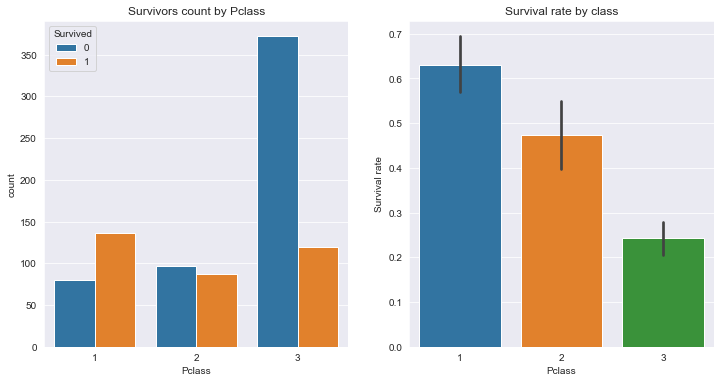

In [14]:
f,g = plt.subplots(1,2,figsize=(12,6))
g[0].set_title('Survivors count by Pclass')
sns.countplot(x='Pclass', hue='Survived', data=train, ax=g[0])
g[1].set_title('Survival rate by class')
b = sns.barplot(x='Pclass', y='Survived', data=train, ax=g[1]).set_ylabel('Survival rate')

In [15]:
# define a mapping
Pclass_target_mean = round( train.groupby('Pclass').Survived.mean() , 3)

# Just map the computed means to each FamilySize
train['Pclass_enc']=train['Pclass'].map(Pclass_target_mean)
test['Pclass_enc']=test['Pclass'].map(Pclass_target_mean)

### Sex

In [16]:
train.groupby('Sex').Survived.mean()

Sex
female    0.742038
male      0.188908
Name: Survived, dtype: float64

Text(0, 0.5, 'Survival rate')

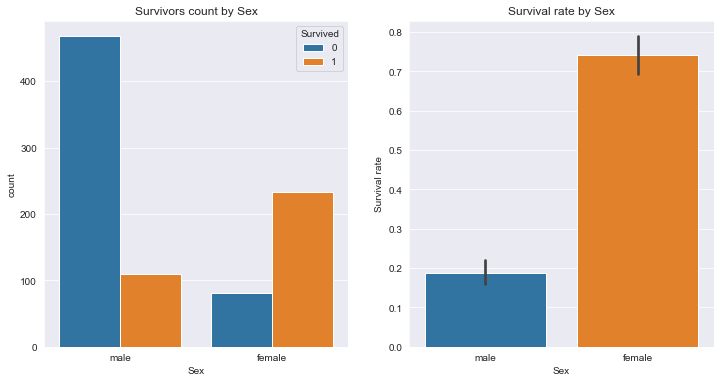

In [17]:
f,g = plt.subplots(1,2,figsize=(12,6))
g[0].set_title('Survivors count by Sex')
sns.countplot(x='Sex', hue='Survived', data=train, ax=g[0])
g[1].set_title('Survival rate by Sex')
sns.barplot(x='Sex', y='Survived', data=train, ax=g[1]).set_ylabel('Survival rate')

In [17]:
train.groupby(['Pclass', 'Sex']).Survived.mean()

Pclass  Sex   
1       female    0.968085
        male      0.368852
2       female    0.921053
        male      0.157407
3       female    0.500000
        male      0.135447
Name: Survived, dtype: float64

The survival rate for women with Pclass 1 or 2 is extremely high! Let's see a countplot:

Text(0, 0.5, 'Survival rate')

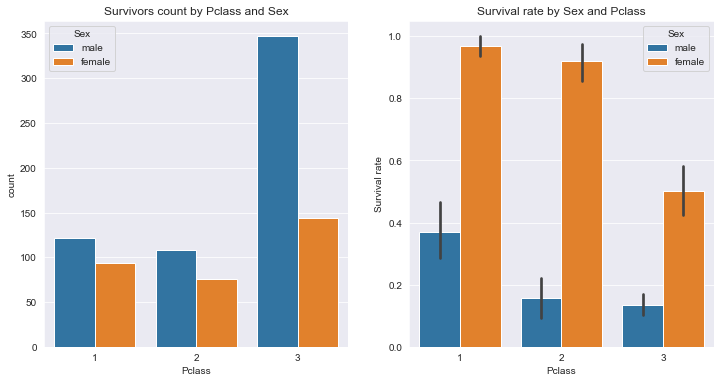

In [18]:
f,g = plt.subplots(1,2,figsize=(12,6))
g[0].set_title('Survivors count by Pclass and Sex')
sns.countplot(x='Pclass', hue='Sex', data=train, ax=g[0])
g[1].set_title('Survival rate by Sex and Pclass')
sns.barplot(x='Pclass', y='Survived', hue='Sex', data=train, ax=g[1]).set_ylabel('Survival rate')

In [19]:
# New Pclass_Sex column
train['Pclass_Sex'] = 'new_col'

def Pclass_Sex(row):
    row['Pclass_Sex'] = str(row.Pclass) + '-' + str(row.Sex)[:2] 
    return row

train = train.apply(Pclass_Sex, axis='columns')
test = test.apply(Pclass_Sex, axis='columns')

In [20]:
train.Pclass_Sex.value_counts()

3-ma    347
3-fe    144
1-ma    122
2-ma    108
1-fe     94
2-fe     76
Name: Pclass_Sex, dtype: int64

In [21]:
#This is essentially mean encoding
train.groupby(['Pclass', 'Sex']).Survived.transform('mean')

0      0.135447
1      0.968085
2      0.500000
3      0.968085
4      0.135447
         ...   
886    0.157407
887    0.968085
888    0.500000
889    0.368852
890    0.135447
Name: Survived, Length: 891, dtype: float64

### Age

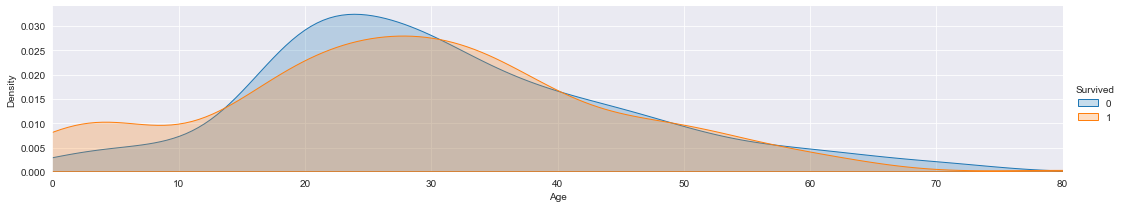

In [20]:
#plot distributions of age of passengers who survived or did not survive

a = sns.FacetGrid( train,hue = 'Survived',  aspect=5)
a.map(sns.kdeplot, 'Age', shade= True )
a.set(xlim=(0, train['Age'].max()))
a.add_legend()

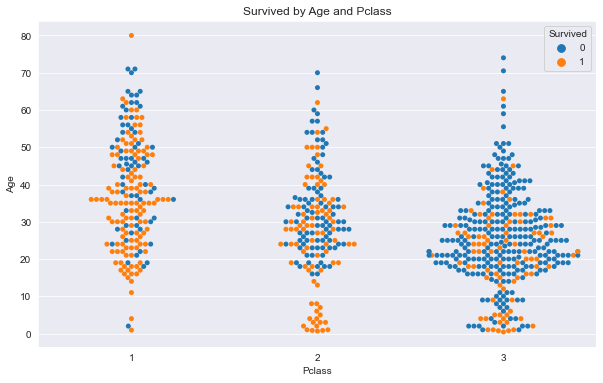

In [19]:
plt.figure(figsize=(10,6))
a=sns.swarmplot(x='Pclass', y='Age', hue='Survived', data=train).set_title('Survived by Age and Pclass')

Text(0, 0.5, 'Survival rate')

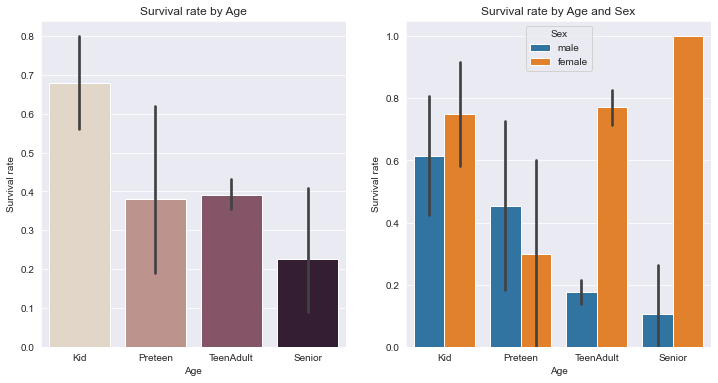

In [18]:
AgeGroup = pd.cut(train.Age, [-1,7, 13,  60,85], labels=['Kid', 'Preteen','TeenAdult', 'Senior'])

f,g = plt.subplots(1,2,figsize=(12,6))
g[0].set_title('Survival rate by Age')
sns.barplot(x=AgeGroup, y=train.Survived, palette="ch:.25", ax=g[0]).set_ylabel('Survival rate')
plt.title('Survival rate by Age and Sex')
sns.barplot(x=AgeGroup, y='Survived', hue='Sex', data=train).set_ylabel('Survival rate')


In [25]:
train['AgeGroup']=pd.cut(train.Age,[-1,7, 13,  60,85], labels=['Kid', 'Preteen','TeenAdult', 'Senior'])
test['AgeGroup']=pd.cut(test.Age,[-1,7, 13,  60,85], labels=['Kid', 'Preteen','TeenAdult', 'Senior'])

### Fare

<Figure size 720x720 with 0 Axes>

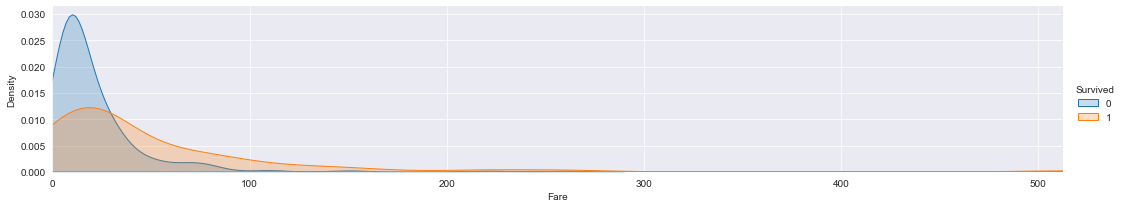

In [26]:
plt.figure(figsize=(10,10))
a = sns.FacetGrid( train,hue = 'Survived', height=3, aspect=5)
#a = sns.FacetGrid( train,  aspect=5)
a.map(sns.kdeplot, 'Fare', shade= True )
a.set(xlim=(0 , train['Fare'].max()))
a.add_legend()

In [27]:
train['Fare'].describe()

count    891.000000
mean      32.204208
std       49.693429
min        0.000000
25%        7.910400
50%       14.454200
75%       31.000000
max      512.329200
Name: Fare, dtype: float64

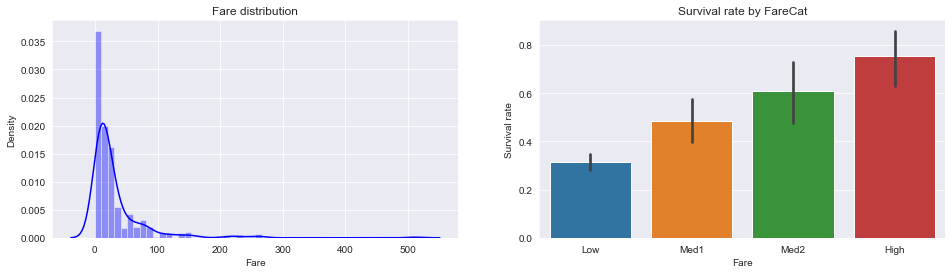

In [28]:
f,g= plt.subplots(1,2,figsize=(16,4))

FareCat = pd.cut(train.Fare, [-1,30,65,90,513], labels=['Low', 'Med1', 'Med2', 'High'])

g[0].set_title('Fare distribution')
sns.distplot(train.Fare, color='b', ax=g[0])

#FareCat = pd.qcut(train.Fare, 4, labels = ['Low', 'Mid', 'High', 'Very high'])
g[1].set_title('Survival rate by FareCat')
g = sns.barplot(x=FareCat, y=train.Survived, ax=g[1]).set_ylabel('Survival rate')

Observe that we have many people with Fare equal to zero. Let's do a bit of data cleaning and fix it now.

In [29]:
train.loc[train.Fare < 5]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Pclass_enc,Pclass_Sex,AgeGroup
179,180,0,3,"Leonard, Mr. Lionel",male,36.0,0,0,LINE,0.0000,NaN,S,0.242,3-ma,TeenAdult
263,264,0,1,"Harrison, Mr. William",male,40.0,0,0,112059,0.0000,B94,S,0.630,1-ma,TeenAdult
271,272,1,3,"Tornquist, Mr. William Henry",male,25.0,0,0,LINE,0.0000,NaN,S,0.242,3-ma,TeenAdult
277,278,0,2,"Parkes, Mr. Francis ""Frank""",male,NaN,0,0,239853,0.0000,NaN,S,0.473,2-ma,NaN
302,303,0,3,"Johnson, Mr. William Cahoone Jr",male,19.0,0,0,LINE,0.0000,NaN,S,0.242,3-ma,TeenAdult
378,379,0,3,"Betros, Mr. Tannous",male,20.0,0,0,2648,4.0125,NaN,C,0.242,3-ma,TeenAdult
413,414,0,2,"Cunningham, Mr. Alfred Fleming",male,NaN,0,0,239853,0.0000,NaN,S,0.473,2-ma,NaN
466,467,0,2,"Campbell, Mr. William",male,NaN,0,0,239853,0.0000,NaN,S,0.473,2-ma,NaN
481,482,0,2,"Frost, Mr. Anthony Wood ""Archie""",male,NaN,0,0,239854,0.0000,NaN,S,0.473,2-ma,NaN
597,598,0,3,"Johnson, Mr. Alfred",male,49.0,0,0,LINE,0.0000,NaN,S,0.242,3-ma,TeenAdult


In [30]:
fpc=train[['Pclass', "Fare"]].groupby(['Pclass']).mean()
fpc.Fare


Pclass
1    84.154687
2    20.662183
3    13.675550
Name: Fare, dtype: float64

In [31]:
def zero_fare(row):
    if row.Fare == 0:
        row.Fare = fpc.Fare[row.Pclass]
    return row

# Apply the function
train = train.apply(zero_fare, axis=1)
test = test.apply(zero_fare, axis=1)

train.loc[train.Fare==0].shape[0],  train.loc[train.Fare==0].shape[0]

(0, 0)

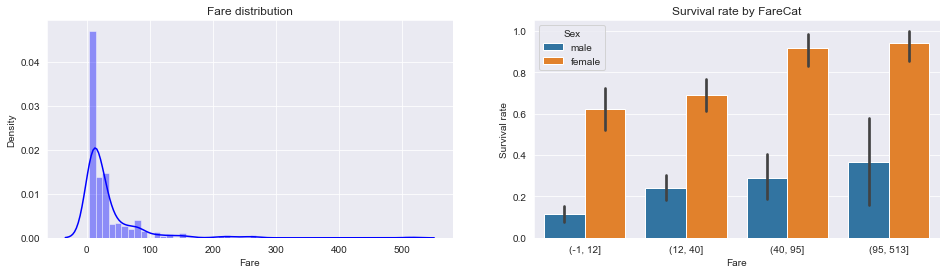

In [32]:
f,g= plt.subplots(1,2,figsize=(16,4))

FareCat = pd.cut(train.Fare, [-1,12, 40, 95, 513])#, labels=['Low', 'Med1', 'Med2', 'High'])
#FareCat=pd.qcut(train.Fare, q=8)

g[0].set_title('Fare distribution')
sns.distplot(train.Fare, color='b', ax=g[0])

#FareCat = pd.qcut(train.Fare, 4, labels = ['Low', 'Mid', 'High', 'Very high'])
g[1].set_title('Survival rate by FareCat')
g = sns.barplot(x=FareCat, y=train.Survived, hue=train.Sex ,ax=g[1]).set_ylabel('Survival rate')

In [33]:
train['FareCat']=pd.cut(train.Fare,[-1,12, 40, 95, 513] , labels=['Low','Med1', 'Med2', 'High'])
test['FareCat']=pd.cut(test.Fare,[-1,22, 40, 95,513],  labels=['Low','Med1', 'Med2', 'High' ])

In [34]:
train.FareCat.value_counts()

Low     359
Med1    351
Med2    128
High     53
Name: FareCat, dtype: int64

In [35]:
# define a mapping

FareCat_target_mean = round( train.groupby('FareCat').Survived.mean() , 3)
FareCat_target_mean

FareCat
Low     0.226
Med1    0.422
Med2    0.578
High    0.736
Name: Survived, dtype: float64

In [36]:
# Just map the computed means to each FamilySize

train['FareCat_enc']=train['FareCat'].map(FareCat_target_mean)
test['FareCat_enc']=test['FareCat'].map(FareCat_target_mean)

#train['FamilySize_enc'].fillna(0.5, inplace=True)

### Name

From the name we extract the title.

In [37]:
train['Title'] = train['Name'].apply(lambda x: x.split(',')[1].split('.')[0].strip())
test['Title'] = test['Name'].apply(lambda x: x.split(',')[1].split('.')[0].strip())

In [38]:
train['Title'].value_counts()

Mr              517
Miss            182
Mrs             125
Master           40
Dr                7
Rev               6
Mlle              2
Major             2
Col               2
the Countess      1
Capt              1
Ms                1
Sir               1
Lady              1
Mme               1
Don               1
Jonkheer          1
Name: Title, dtype: int64

In [39]:
train.groupby('Title').Survived.mean().sort_values(ascending=False)


Title
the Countess    1.000000
Mlle            1.000000
Sir             1.000000
Ms              1.000000
Lady            1.000000
Mme             1.000000
Mrs             0.792000
Miss            0.697802
Master          0.575000
Col             0.500000
Major           0.500000
Dr              0.428571
Mr              0.156673
Jonkheer        0.000000
Rev             0.000000
Don             0.000000
Capt            0.000000
Name: Survived, dtype: float64

In [40]:
titles = {
    "Mr" :         "Mr",
    
    "Mme":         "Mrs",
    "Ms":          "Mrs",
    "Mrs" :        "Mrs",
    
    "Mlle":        "Miss",
    "Miss" :       "Miss",
    
    "Master" :     "Master",
    
    "Capt":        "Mr", # or 'Mr'
    "Col":         "Mr",
    "Major":       "Mr",
    "Dr":          "Dr",
    
    "Rev":         "Mr",
    "Jonkheer":    "Mr",
    "Don":         "Mr",
    
    "Sir" :        "Royalty",
    "the Countess":    "Royalty",
    "Dona":        "Royalty",
    "Lady" :       "Royalty"
}


train["Title"] =train['Title'].map(titles)
test['Title']=test['Title'].map(titles)

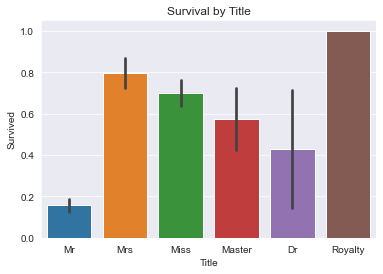

In [41]:
a=sns.barplot(data=train, x='Title', y='Survived').set_title('Survival by Title')

In [42]:
train.Title.value_counts()

Mr         530
Miss       184
Mrs        127
Master      40
Dr           7
Royalty      3
Name: Title, dtype: int64

In [43]:
train['Surname'] = train['Name'].apply(lambda x: x.split(',')[0])
test['Surname'] = test['Name'].apply(lambda x: x.split(',')[0])

### SibSp

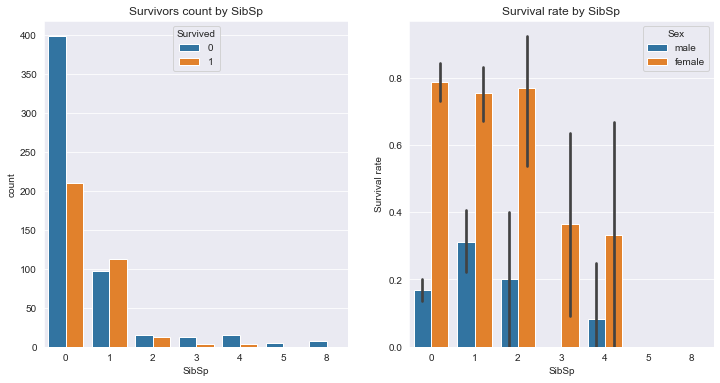

In [44]:
f,g = plt.subplots(1,2,figsize=(12,6))
g[0].set_title('Survivors count by SibSp')
sns.countplot(x='SibSp', hue='Survived', data=train, ax=g[0])
g[1].set_title('Survival rate by SibSp')
b = sns.barplot(x='SibSp', y='Survived', hue=train.Sex, data=train, ax=g[1]).set_ylabel('Survival rate')


### Parch

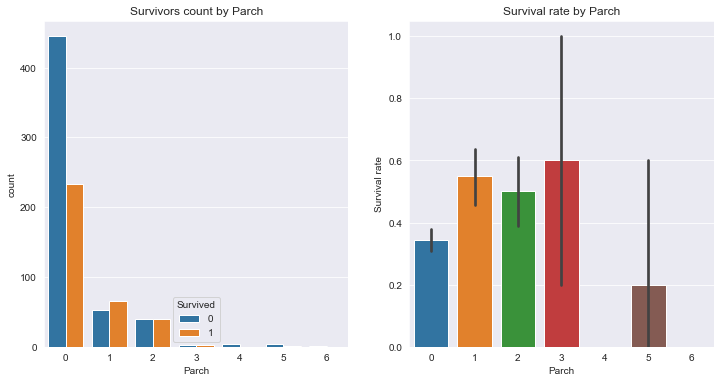

In [45]:
f,g = plt.subplots(1,2,figsize=(12,6))
g[0].set_title('Survivors count by Parch')
sns.countplot(x='Parch', hue='Survived', data=train, ax=g[0])
g[1].set_title('Survival rate by Parch')
b = sns.barplot(x='Parch', y='Survived', data=train, ax=g[1]).set_ylabel('Survival rate')

In [46]:
train["RelativesOnBoard"] = train["SibSp"] + train["Parch"]
test['RelativesOnBoard'] = test["SibSp"] + test["Parch"]

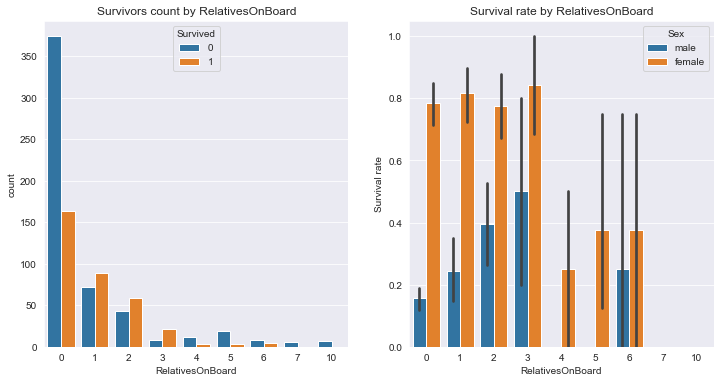

In [47]:
f,g = plt.subplots(1,2,figsize=(12,6))
g[0].set_title('Survivors count by RelativesOnBoard')
sns.countplot(x='RelativesOnBoard', hue='Survived', data=train, ax=g[0])
g[1].set_title('Survival rate by RelativesOnBoard')
b = sns.barplot(x='RelativesOnBoard', y='Survived', hue='Sex', data=train, ax=g[1]).set_ylabel('Survival rate')

In [48]:
# Creation of four groups
train['FamilySize'] = pd.cut(train.RelativesOnBoard, [-1,0,2,3,5,6,11], labels=['Alone', 'onetwo', 'three', 'fourfive', 'six', 'sevenup'])
test['FamilySize'] = pd.cut(test.RelativesOnBoard, [-1,0,2,3,5,6,11], labels=['Alone', 'onetwo', 'three', 'fourfive', 'six', 'sevenup'])
# right == True  is the default

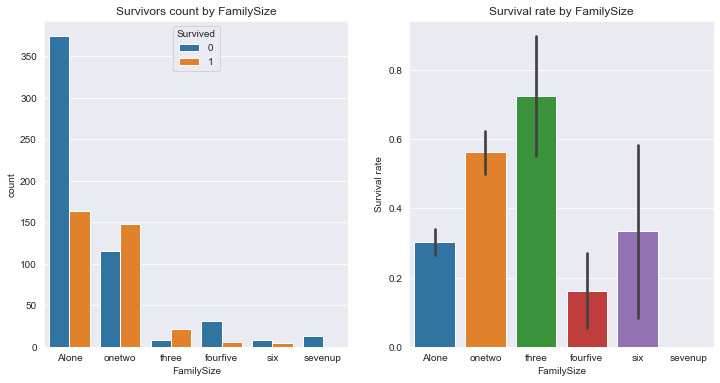

In [49]:
f,g = plt.subplots(1,2,figsize=(12,6))
g[0].set_title('Survivors count by FamilySize')
sns.countplot(x='FamilySize', hue='Survived', data=train, ax=g[0])
g[1].set_title('Survival rate by FamilySize')
b = sns.barplot(x='FamilySize', y='Survived', data=train, ax=g[1]).set_ylabel('Survival rate')

In [50]:
# define a mapping
FamilySize_target_mean = round( train.groupby('FamilySize').Survived.mean() , 3)

# Just map the computed means to each FamilySize
train['FamilySize_enc']=train['FamilySize'].map(FamilySize_target_mean)
test['FamilySize_enc']=test['FamilySize'].map(FamilySize_target_mean)

Text(0, 0.5, 'Survival rate')

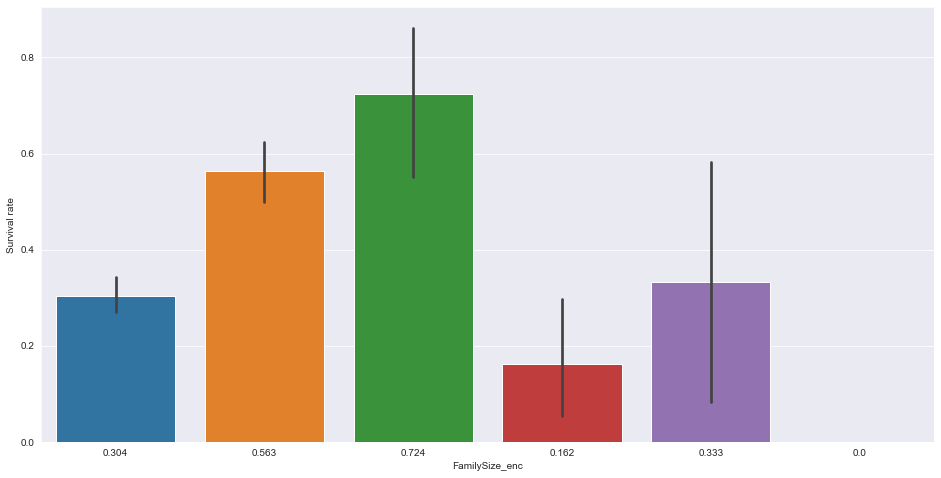

In [51]:
plt.figure(figsize=(16,8))
sns.barplot(x='FamilySize_enc', y='Survived', data=train).set_ylabel('Survival rate')

### Embarked

Southampton, Cherbourg and Queenstown.

In [52]:
train.Embarked.describe()

count     889
unique      3
top         S
freq      644
Name: Embarked, dtype: object

In [53]:
train[ pd.isnull(train['Embarked']) ]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,...,Pclass_enc,Pclass_Sex,AgeGroup,FareCat,FareCat_enc,Title,Surname,RelativesOnBoard,FamilySize,FamilySize_enc
61,62,1,1,"Icard, Miss. Amelie",female,38.0,0,0,113572,80.0,...,0.63,1-fe,TeenAdult,Med2,0.578,Miss,Icard,0,Alone,0.304
829,830,1,1,"Stone, Mrs. George Nelson (Martha Evelyn)",female,62.0,0,0,113572,80.0,...,0.63,1-fe,Senior,Med2,0.578,Mrs,Stone,0,Alone,0.304


In [54]:
train[ train['Ticket']=='113572' ]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,...,Pclass_enc,Pclass_Sex,AgeGroup,FareCat,FareCat_enc,Title,Surname,RelativesOnBoard,FamilySize,FamilySize_enc
61,62,1,1,"Icard, Miss. Amelie",female,38.0,0,0,113572,80.0,...,0.63,1-fe,TeenAdult,Med2,0.578,Miss,Icard,0,Alone,0.304
829,830,1,1,"Stone, Mrs. George Nelson (Martha Evelyn)",female,62.0,0,0,113572,80.0,...,0.63,1-fe,Senior,Med2,0.578,Mrs,Stone,0,Alone,0.304


We have two missing values. Those two women travelled together since they have the same ticket number. 

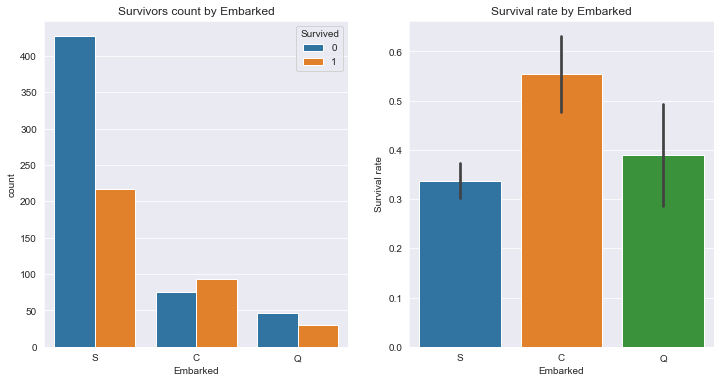

In [55]:
f,g = plt.subplots(1,2,figsize=(12,6))
g[0].set_title('Survivors count by Embarked')
sns.countplot(x='Embarked', hue='Survived', data=train, ax=g[0])
g[1].set_title('Survival rate by Embarked')
b = sns.barplot(x='Embarked', y='Survived', data=train, ax=g[1]).set_ylabel('Survival rate')

In [56]:
train.groupby(['Embarked']).Fare.mean()

Embarked
C    59.954144
Q    13.276030
S    28.010633
Name: Fare, dtype: float64

### Ticket

We use it to create a new column: FriendsOnBoard

In [57]:
ticket_df=train.Ticket.value_counts()  #Series
ticket_df

347082      7
CA. 2343    7
1601        7
3101295     6
CA 2144     6
           ..
9234        1
19988       1
2693        1
PC 17612    1
370376      1
Name: Ticket, Length: 681, dtype: int64

In [58]:
def friendsnumber(row):
    ticket=row.Ticket
    p=0
    for index,value in ticket_df.items():
        if index==ticket:
            p=value
    q=max(p, row.RelativesOnBoard+1)
    return q
        
        
train['FriendsOnBoard'] = train.apply(friendsnumber, axis=1)
test['FriendsOnBoard'] = test.apply(friendsnumber, axis=1)

In [59]:
train.FriendsOnBoard.value_counts()

1     462
2     185
3     128
4      42
6      22
5      20
7      19
11      7
8       6
Name: FriendsOnBoard, dtype: int64

In [60]:
train.FriendsOnBoard.describe()

count    891.000000
mean       2.103255
std        1.688860
min        1.000000
25%        1.000000
50%        1.000000
75%        3.000000
max       11.000000
Name: FriendsOnBoard, dtype: float64

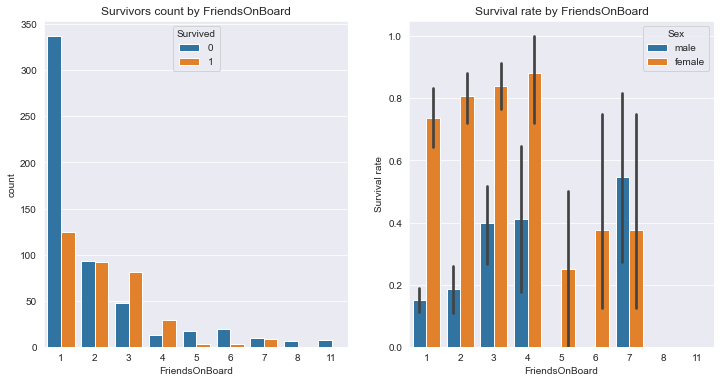

In [61]:
f,g = plt.subplots(1,2,figsize=(12,6))
g[0].set_title('Survivors count by FriendsOnBoard')
sns.countplot(x='FriendsOnBoard', hue='Survived', data=train, ax=g[0])
g[1].set_title('Survival rate by FriendsOnBoard')
b = sns.barplot(x='FriendsOnBoard', y='Survived', hue="Sex", data=train, ax=g[1]).set_ylabel('Survival rate')

In [62]:
# New Pclass_Sex column
train['Ticket_Surname'] = 'new_col'

def Ticket_Surname(row):
    row['Ticket_Surname'] = str(row.Ticket)[:-2] + '-' + str(row.Surname) 
    return row

train = train.apply(Ticket_Surname, axis='columns')
test = test.apply(Ticket_Surname, axis='columns')

In [63]:
train['Ticket_Surname'].value_counts()

3470-Andersson    7
CA. 23-Sage       7
31012-Panula      6
CA 21-Goodwin     6
3470-Skoog        6
                 ..
3474-Nilsson      1
290-Moraweck      1
169-Spedden       1
A/5 211-Dennis    1
3703-Dooley       1
Name: Ticket_Surname, Length: 718, dtype: int64

In [64]:
# define a mapping
Ticket_Surname_target_mean = round( train.groupby('Ticket_Surname').Survived.mean() , 3)

# Just map the computed means to each FamilySize
train['Ticket_Surname_enc']=train['Ticket_Surname'].map(Ticket_Surname_target_mean)
test['Ticket_Surname_enc']=test['Ticket_Surname'].map(Ticket_Surname_target_mean)

train['Ticket_Surname_enc'].fillna(0.3, inplace=True)
test['Ticket_Surname_enc'].fillna(0.3, inplace=True)

In [65]:
train.Ticket_Surname_enc.nunique(), test.Ticket_Surname_enc.nunique()

(6, 7)

In [66]:
train.Ticket_Surname_enc.value_counts()

0.000    506
1.000    289
0.500     62
0.667     27
0.750      4
0.333      3
Name: Ticket_Surname_enc, dtype: int64

In [67]:
train['Ticket_cr'] = train['Ticket'].apply(lambda x: x[:-2])
test['Ticket_cr'] = test['Ticket'].apply(lambda x: x[:-2])

In [68]:
train.groupby('Ticket_cr').Survived.mean()

Ticket_cr
1101         1.0
1104         0.4
1105         1.0
1108         1.0
1112         0.0
            ... 
W./C. 142    0.5
W./C. 66     0.0
W.E.P. 57    0.0
W/C 142      0.0
WE/P 57      0.5
Name: Survived, Length: 250, dtype: float64

In [69]:
# define a mapping

Ticket_cr_target_mean = round( train.groupby('Ticket_cr').Survived.mean() , 3)

# Just map the computed means to each FamilySize

train['Ticket_cr_enc']=train['Ticket_cr'].map(Ticket_cr_target_mean)
test['Ticket_cr_enc']=test['Ticket_cr'].map(Ticket_cr_target_mean)

#train['Ticket_cr_enc'].fillna(0.3, inplace=True)
test['Ticket_cr_enc'].fillna(0.33, inplace=True)

In [70]:
test.Ticket_cr_enc.isnull().value_counts()

False    418
Name: Ticket_cr_enc, dtype: int64

### Cabin

In [71]:
train[ pd.notnull(train['Cabin']) ]['Pclass'].value_counts()

1    176
2     16
3     12
Name: Pclass, dtype: int64

The Cabins are mostly for 1st class (Pclass) passengers. 

In [72]:
train['Deck']=train['Cabin'].map(lambda x: str(x)[0])
test['Deck']=test['Cabin'].map(lambda x: str(x)[0])

In [73]:
train['Deck'].value_counts()

n    687
C     59
B     47
D     33
E     32
A     15
F     13
G      4
T      1
Name: Deck, dtype: int64

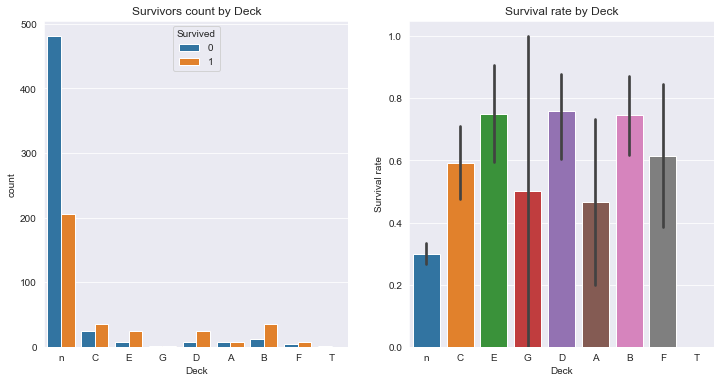

In [74]:
f,g = plt.subplots(1,2,figsize=(12,6))
g[0].set_title('Survivors count by Deck')
sns.countplot(x='Deck', hue='Survived', data=train, ax=g[0])
g[1].set_title('Survival rate by Deck')
b = sns.barplot(x='Deck', y='Survived', data=train, ax=g[1]).set_ylabel('Survival rate')

In [75]:
deckdict={
    'A':'AG',
    'B':'BDE',
    'C': 'CF',
    'D':'BDE',
    'E':'BDE',
    'F':'CF',
    'G':'AG',
    'T':'T',
    'n':'n'
    }

train['Deck']=train['Deck'].map(deckdict)
test['Deck']=test['Deck'].map(deckdict)

In [76]:
train.Deck.value_counts()

n      687
BDE    112
CF      72
AG      19
T        1
Name: Deck, dtype: int64

# Data Preprocessing

## Missing Values

Fill in Missing Values, Drop attributes that are not useful, add other promising features

In [77]:
train.columns

Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked', 'Pclass_enc',
       'Pclass_Sex', 'AgeGroup', 'FareCat', 'FareCat_enc', 'Title', 'Surname',
       'RelativesOnBoard', 'FamilySize', 'FamilySize_enc', 'FriendsOnBoard',
       'Ticket_Surname', 'Ticket_Surname_enc', 'Ticket_cr', 'Ticket_cr_enc',
       'Deck'],
      dtype='object')

In [78]:
test.columns

Index(['PassengerId', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp', 'Parch',
       'Ticket', 'Fare', 'Cabin', 'Embarked', 'Pclass_enc', 'Pclass_Sex',
       'AgeGroup', 'FareCat', 'FareCat_enc', 'Title', 'Surname',
       'RelativesOnBoard', 'FamilySize', 'FamilySize_enc', 'FriendsOnBoard',
       'Ticket_Surname', 'Ticket_Surname_enc', 'Ticket_cr', 'Ticket_cr_enc',
       'Deck'],
      dtype='object')

In [79]:
total = train.isnull().sum().sort_values(ascending=False)
ratio = (train.isnull().sum()/train.isnull().count()).sort_values(ascending=False)
missing_data_train = pd.concat([total, ratio], axis=1, keys=['Total', 'Percentage'])

missing_data_train

,Total,Percentage
Cabin,687,0.771044
AgeGroup,177,0.198653
Age,177,0.198653
Embarked,2,0.002245
FareCat_enc,0,0.000000
Ticket_cr_enc,0,0.000000
Ticket_cr,0,0.000000
Ticket_Surname_enc,0,0.000000
Ticket_Surname,0,0.000000
FriendsOnBoard,0,0.000000


In [80]:
total = test.isnull().sum().sort_values(ascending=False)
ratio = (test.isnull().sum()/test.isnull().count()).sort_values(ascending=False)
missing_data_test = pd.concat([total, ratio], axis=1, keys=['Total', 'Percentage'])

missing_data_test

,Total,Percentage
Cabin,327,0.782297
AgeGroup,86,0.205742
Age,86,0.205742
Fare,1,0.002392
FareCat,1,0.002392
FareCat_enc,1,0.002392
Title,0,0.000000
Ticket_cr_enc,0,0.000000
Ticket_cr,0,0.000000
Ticket_Surname_enc,0,0.000000


We don't need Age as this is included in the title. We will keep the AgeGroup though, filling in the missing values according to the title.

In [81]:
apt=train[['Title', "Age"]].groupby(['Title']).mean()
apt

,Age
Title,
Dr,42.000000
Master,4.574167
Miss,21.804054
Mr,32.852798
Mrs,35.718182
Royalty,43.333333


In [82]:
def agegroup(row):
    agegp=row.AgeGroup
    if agegp not in {'Kid','Preteen', 'TeenAdult', 'Senior'}:
        if row.Title == 'Master':
            return 'Kid'
        else:
            return 'TeenAdult'
    else:
        return agegp
    
train['AgeGroup'] = train.apply(agegroup, axis=1)
test['AgeGroup'] = test.apply(agegroup, axis=1)    

In [83]:
train.columns

Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked', 'Pclass_enc',
       'Pclass_Sex', 'AgeGroup', 'FareCat', 'FareCat_enc', 'Title', 'Surname',
       'RelativesOnBoard', 'FamilySize', 'FamilySize_enc', 'FriendsOnBoard',
       'Ticket_Surname', 'Ticket_Surname_enc', 'Ticket_cr', 'Ticket_cr_enc',
       'Deck'],
      dtype='object')

## Select features to include for modelling

In [84]:
# Select features to include 

features = [ 'Pclass' ,
            'Age',
            'Fare',  
            'Embarked', 
            'FamilySize_enc', 
            'Title'
            ]


In [85]:
X_train_0 = train[features]
X_test_0 = test[X_train_0.columns]
y_train = train['Survived']

X_train_0.tail(5)

,Pclass,Age,Fare,Embarked,FamilySize_enc,Title
886,2,27.0,13.00,S,0.304,Mr
887,1,19.0,30.00,S,0.304,Miss
888,3,NaN,23.45,S,0.724,Miss
889,1,26.0,30.00,C,0.304,Mr
890,3,32.0,7.75,Q,0.304,Mr


In [86]:
X_test_0.head()

,Pclass,Age,Fare,Embarked,FamilySize_enc,Title
0,3,34.5,7.8292,Q,0.304,Mr
1,3,47.0,7.0000,S,0.563,Mrs
2,2,62.0,9.6875,Q,0.304,Mr
3,3,27.0,8.6625,S,0.304,Mr
4,3,22.0,12.2875,S,0.563,Mrs


## Transformation Pipelines

In [87]:
numerical_features = X_train_0.dtypes[X_train_0.dtypes != 'object'].index
numerical_features

Index(['Pclass', 'Age', 'Fare', 'FamilySize_enc'], dtype='object')

In [88]:
# Set the numerical columns. The rest will be categorical
numerical_cols = [ 'Age', 'Fare', 'FamilySize_enc']

In [89]:
categorical_cols=[x for x in features if x not in numerical_cols]
categorical_cols

['Pclass', 'Embarked', 'Title']

In [90]:
# Preprocessing for numerical data
numerical_transformer = SimpleImputer(strategy='median')

# Preprocessing for categorical data
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
    #('ordinal_enc', OrdinalEncoder() )

])

# Bundle preprocessing for numerical and categorical data
preprocessor_pipeline = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_cols),
        ('cat', categorical_transformer, categorical_cols),
                    ])

In [91]:
# Transform the data and get a df

X_train=preprocessor_pipeline.fit_transform(X_train_0)#.toarray()
X_test=preprocessor_pipeline.transform(X_test_0)#.toarray()

In [92]:
X_train.shape, X_test.shape

((891, 15), (418, 15))

In [93]:
features

['Pclass', 'Age', 'Fare', 'Embarked', 'FamilySize_enc', 'Title']

In [94]:
ohe = OneHotEncoder(handle_unknown='ignore')
ohe.fit( X_train_0[categorical_cols].dropna(axis=0) )
features_cat=list( ohe.get_feature_names(categorical_cols)  )
features_enc=numerical_cols+features_cat
features_enc

['Age',
 'Fare',
 'FamilySize_enc',
 'Pclass_1',
 'Pclass_2',
 'Pclass_3',
 'Embarked_C',
 'Embarked_Q',
 'Embarked_S',
 'Title_Dr',
 'Title_Master',
 'Title_Miss',
 'Title_Mr',
 'Title_Mrs',
 'Title_Royalty']

In [95]:
try:
    X_train=pd.DataFrame(data=X_train,columns=features_enc).astype({'Age': int, 'Fare':int})
    X_test=pd.DataFrame(data=X_test,columns=features_enc).astype({'Age': int, 'Fare':int})
except:
    X_train=pd.DataFrame(data=X_train,columns=features)#.astype(int)
    X_test=pd.DataFrame(data=X_test,columns=features)#.astype(int)

In [96]:
X_train.isnull().sum().max()

0

In [97]:
X_test.isnull().sum().max()

0

<AxesSubplot:>

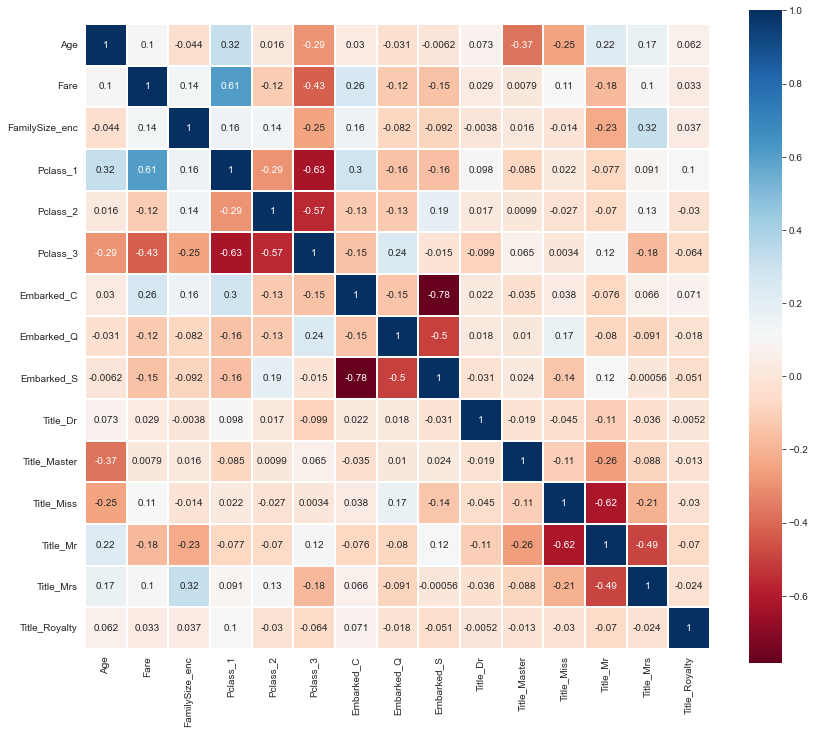

In [98]:
# Pearson Correlation Heatmap

corr_matrix = X_train.corr()

f, ax = plt.subplots(figsize=(14, 12))
colormap = plt.cm.RdBu
sns.heatmap(corr_matrix,linewidths=0.1,vmax=1.0, 
            square=True, cmap=colormap, linecolor='white', 
            annot=True)   #, cmap = 'Reds')  #, annot=True)

In [99]:
#pairs_corr = corr_matrix.abs().unstack()
pairs_corr = corr_matrix.unstack()
sorted_pairs = pairs_corr.sort_values(kind="quicksort", ascending=False)


sorted_pairs[   (abs(sorted_pairs)>.5)  & (sorted_pairs!=1)   ].drop_duplicates()

Fare        Pclass_1      0.606225
Pclass_2    Pclass_3     -0.565210
Title_Mr    Title_Miss   -0.618135
Pclass_3    Pclass_1     -0.626738
Embarked_S  Embarked_C   -0.782742
dtype: float64

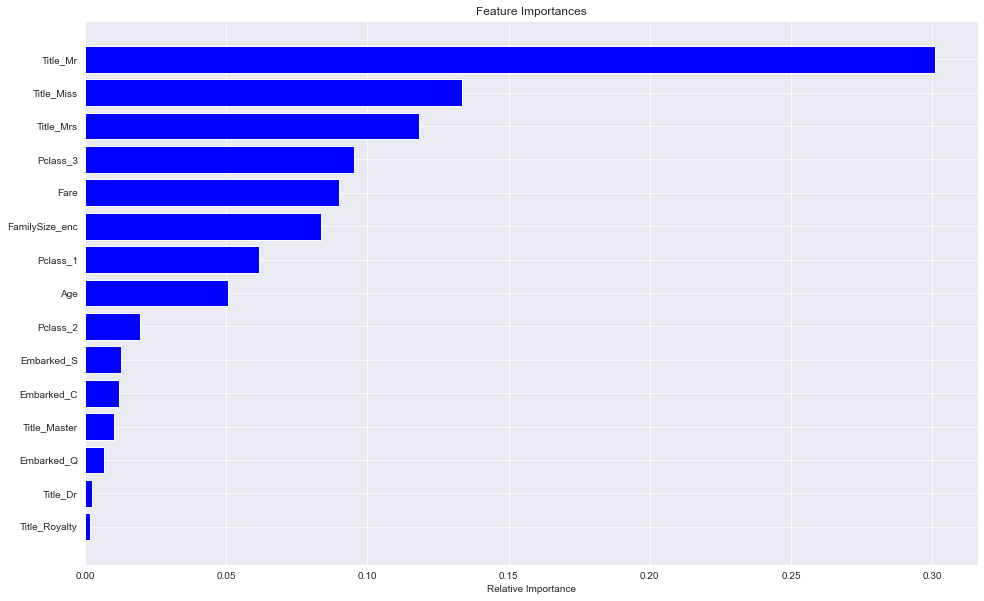

In [100]:
rf_clf_fi = RandomForestClassifier(n_estimators=400, 
                                    max_depth=4, 
                                   class_weight= {0:6,1:4},
                                random_state=0)
rf_clf_fi.fit(X_train,y_train)

importances = rf_clf_fi.feature_importances_
indices = np.argsort(importances)

plt.figure(figsize=(16,10))
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), [features_enc[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

#plt.barh(features, rf_clf.feature_importances_)

In [101]:
features_enc

['Age',
 'Fare',
 'FamilySize_enc',
 'Pclass_1',
 'Pclass_2',
 'Pclass_3',
 'Embarked_C',
 'Embarked_Q',
 'Embarked_S',
 'Title_Dr',
 'Title_Master',
 'Title_Miss',
 'Title_Mr',
 'Title_Mrs',
 'Title_Royalty']

In [102]:
# Drop some columns

dropcolumns=[
                'Embarked_Q'
               ,'Title_Royalty'
]

X_train= X_train[[x for x in features_enc if x not in dropcolumns]]
X_test=X_test[X_train.columns]

if X_train.shape[1] == X_test.shape[1]:
    print("""  --> The X_train and X_test are ready.
            """)

    

  --> The X_train and X_test are ready.
            


In [103]:
X_train.head()

,Age,Fare,FamilySize_enc,Pclass_1,Pclass_2,Pclass_3,Embarked_C,Embarked_S,Title_Dr,Title_Master,Title_Miss,Title_Mr,Title_Mrs
0,22,7,0.563,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
1,38,71,0.563,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
2,26,7,0.304,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
3,35,53,0.563,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
4,35,8,0.304,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0


In [104]:
X_test.head()

,Age,Fare,FamilySize_enc,Pclass_1,Pclass_2,Pclass_3,Embarked_C,Embarked_S,Title_Dr,Title_Master,Title_Miss,Title_Mr,Title_Mrs
0,34,7,0.304,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,47,7,0.563,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
2,62,9,0.304,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3,27,8,0.304,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
4,22,12,0.563,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0


# Modelling

## Train various models, then shortlist the top 3

In [106]:
models_list=[]

In [107]:
# Logistic Regression

log_reg = LogisticRegression(class_weight={0:6,1:4} )
log_reg_p=make_pipeline(StandardScaler(), log_reg)

models_list.append(log_reg_p)

In [108]:
# Random Forest Classifier

criteria=['gini']#, 'entropy']
max_depth=[4]  #3,4
n_estimators=[ 750, 1000] #250,500, 750,
min_samples_split=[2,3,4]
min_samples_leaf=[1,2,3]
#max_features=['auto', 'sqrt', 'log2', 10]
max_features=['auto']
class_weight=[{0:6,1:4}]

grid_search_rfc=GridSearchCV(estimator=RandomForestClassifier(),  
                             param_grid={'max_depth': max_depth, 
                                         'n_estimators': n_estimators, 
                                         'criterion': criteria,
                                         'class_weight': class_weight,
                                         'min_samples_split': min_samples_split,
                                            'min_samples_leaf':min_samples_leaf,
                                         'max_features':max_features
                                        }  ,
                             scoring = 'accuracy',
                             n_jobs=-1)

grid_search_rfc.fit(X_train, y_train)

rf_clf = RandomForestClassifier(max_depth=grid_search_rfc.best_params_['max_depth'], 
                                n_estimators=grid_search_rfc.best_params_['n_estimators'], 
                                criterion=grid_search_rfc.best_params_['criterion'],
                                class_weight= grid_search_rfc.best_params_['class_weight'],
                                min_samples_split= grid_search_rfc.best_params_['min_samples_split'],
                                min_samples_leaf= grid_search_rfc.best_params_['min_samples_leaf'],
                                max_features= grid_search_rfc.best_params_['max_features'],

                                random_state=0)

models_list.append(rf_clf)


In [109]:
rf_clf

RandomForestClassifier(class_weight={0: 6, 1: 4}, max_depth=4,
                       min_samples_leaf=3, n_estimators=1000, random_state=0)

In [110]:
# BEST so far

rf_clf_best=RandomForestClassifier(class_weight={0: 6, 1: 4}, max_depth=4,
                       min_samples_leaf=2, min_samples_split=3,
                       n_estimators=750, random_state=0)
                       
models_list.append(rf_clf_best)


Before: RandomForestClassifier(class_weight={0: 6, 1: 4}, max_depth=4,
                       n_estimators=1000, random_state=0)

In [111]:
# KNN

k=range(1,20,2)
algorithm = ['auto']
weights = ['uniform', 'distance']
leaf_size = list(range(1,50,5))
metric=['euclidean',  'manhattan' , 'chebyshev' , 'minkowski']
grid_search_knn=GridSearchCV(  estimator=KNeighborsClassifier(),
                            param_grid={'n_neighbors': k, 
                                        'algorithm': algorithm, 
                                        'weights': weights, 
                                        'leaf_size': leaf_size,
                                        'metric':metric
                                       },
                            scoring='roc_auc',
                             n_jobs=-1,
                             verbose=1
                            )



grid_search_knn.fit(X_train, y_train)
knn = KNeighborsClassifier(n_neighbors = grid_search_knn.best_params_['n_neighbors'],
                          algorithm = grid_search_knn.best_params_['algorithm'],
                          weights = grid_search_knn.best_params_['weights'],
                          leaf_size = grid_search_knn.best_params_['leaf_size'],
                          metric = grid_search_knn.best_params_['metric']
                          )



knnp=make_pipeline(StandardScaler(),
                           knn)

models_list.append(knnp)

print(grid_search_knn.best_estimator_  ,'and the score is',  grid_search_knn.best_score_)


Fitting 5 folds for each of 800 candidates, totalling 4000 fits
KNeighborsClassifier(leaf_size=6, metric='manhattan', n_neighbors=7) and the score is 0.776365899189933


In [112]:
#  xgboost

eta =[0.01, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.7, 0.9] # default is 0.3, learning parameter
max_depth=[4,5,6,7] # default is 6
n_estimators=[500, 1000, 2000]
gamma =[0.9]
min_child_weight=[2,3,4]
colsample_bytree=[0.8]
objective= ['binary:logistic']
subsample=[0.8]
#early_stopping_rounds=[5]
# np.random.uniform(low, high, size) ->  [low, high)

grid_search_xgb=GridSearchCV(estimator=XGBClassifier(), 
                             param_grid={
                                 'eta': eta ,
                                 'max_depth':max_depth,
                                 'n_estimators' :n_estimators,
                                 'gamma' :gamma,
                                 'min_child_weight' :min_child_weight ,
                                 'colsample_bytree' :colsample_bytree,
                                 'objective':objective
                                 ,'subsample' :subsample
                                 #,'early_stopping_rounds':early_stopping_rounds
                                 }, 
                             scoring='accuracy', 
                             verbose=1,
                             n_jobs=-1)

grid_search_xgb.fit(X_train, y_train)


xgb=XGBClassifier(eval_metric='error', verbosity = 0, 
                  eta=grid_search_xgb.best_params_['eta'],
                  max_depth=grid_search_xgb.best_params_['max_depth'],
                  n_estimators=grid_search_xgb.best_params_['n_estimators'],
                  gamma=grid_search_xgb.best_params_['gamma'],
                  min_child_weight=grid_search_xgb.best_params_['min_child_weight'],
                  colsample_bytree=grid_search_xgb.best_params_['colsample_bytree'],
                  objective=grid_search_xgb.best_params_['objective'],
                  subsample=grid_search_xgb.best_params_['subsample']
                  #,early_stopping_rounds=grid_search_xgb.best_params_['early_stopping_rounds']
                 )


models_list.append(xgb)

Fitting 5 folds for each of 324 candidates, totalling 1620 fits
[14:03:42] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [113]:
xgb

XGBClassifier(base_score=None, booster=None, colsample_bylevel=None,
              colsample_bynode=None, colsample_bytree=0.8,
              enable_categorical=False, eta=0.3, eval_metric='error', gamma=0.9,
              gpu_id=None, importance_type=None, interaction_constraints=None,
              learning_rate=None, max_delta_step=None, max_depth=6,
              min_child_weight=4, missing=nan, monotone_constraints=None,
              n_estimators=500, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, reg_alpha=None,
              reg_lambda=None, scale_pos_weight=None, subsample=0.8,
              tree_method=None, validate_parameters=None, verbosity=0)

In [114]:
sklearn.metrics.SCORERS.keys()

dict_keys(['explained_variance', 'r2', 'max_error', 'neg_median_absolute_error', 'neg_mean_absolute_error', 'neg_mean_absolute_percentage_error', 'neg_mean_squared_error', 'neg_mean_squared_log_error', 'neg_root_mean_squared_error', 'neg_mean_poisson_deviance', 'neg_mean_gamma_deviance', 'accuracy', 'top_k_accuracy', 'roc_auc', 'roc_auc_ovr', 'roc_auc_ovo', 'roc_auc_ovr_weighted', 'roc_auc_ovo_weighted', 'balanced_accuracy', 'average_precision', 'neg_log_loss', 'neg_brier_score', 'adjusted_rand_score', 'rand_score', 'homogeneity_score', 'completeness_score', 'v_measure_score', 'mutual_info_score', 'adjusted_mutual_info_score', 'normalized_mutual_info_score', 'fowlkes_mallows_score', 'precision', 'precision_macro', 'precision_micro', 'precision_samples', 'precision_weighted', 'recall', 'recall_macro', 'recall_micro', 'recall_samples', 'recall_weighted', 'f1', 'f1_macro', 'f1_micro', 'f1_samples', 'f1_weighted', 'jaccard', 'jaccard_macro', 'jaccard_micro', 'jaccard_samples', 'jaccard_wei

In [115]:
# Gradient Boosting Classifier


grid_search_gbc=GridSearchCV(estimator=GradientBoostingClassifier(), param_grid={'n_estimators': [80, 120], 
                             'max_depth': [3,4]},
                             scoring='accuracy', n_jobs=-1)
grid_search_gbc.fit(X_train, y_train)

gbc=GradientBoostingClassifier(max_depth= grid_search_gbc.best_params_['max_depth'] ,
                                 n_estimators= grid_search_gbc.best_params_['n_estimators'],
                               max_features='auto'
)


models_list.append(gbc)

In [116]:
# LightGBM classification

depths=[2,3,4]

grid_search_lgbm= GridSearchCV(estimator= lightgbm.LGBMClassifier(), param_grid={'max_depth': depths} ,
                               scoring='accuracy',  n_jobs=-1 )
grid_search_lgbm.fit(X_train, y_train)

lgbm=lightgbm.LGBMClassifier(n_estimators=90, max_depth=grid_search_lgbm.best_params_['max_depth']
                             ,  num_leaves = 6 
                            , min_child_samples=10 #default
                            )
                               

models_list.append(lgbm)

In [117]:
# AdaBoost Classifier

rate=[0.1, 0.3, 0.5, 0.8, 1]
grid_search_ada=GridSearchCV(estimator=AdaBoostClassifier(), param_grid={'learning_rate': rate, 
                                                                         'n_estimators':[50, 70, 100]} ,
                            scoring='accuracy', n_jobs=-1)
grid_search_ada.fit(X_train, y_train)


ada = AdaBoostClassifier(n_estimators=grid_search_ada.best_params_['n_estimators'], 
                         learning_rate=grid_search_ada.best_params_['learning_rate'])  #,
                        #random_state=)

models_list.append(ada)

In [118]:
# LinearSVC

svcp=make_pipeline(StandardScaler(),
                           LinearSVC( random_state=42))

models_list.append(svcp)

## Models Comparison

In [119]:
def ModelsComp(cv_number=7, k=7, list=models_list, metric='roc_auc'):
    models_df=pd.DataFrame()
    for model in list:
        models_df[model.__class__.__name__+ '-'+  str(list.index(model))]=cross_val_score(model, X_train, y_train, cv=cv_number, scoring=metric)
        #models_df[model]=cross_val_score(model, X_train, y_train, cv=cv_number, scoring=metric)

    models_df_t=models_df.T
    models_df_t
    models_df_t.insert(0, 'MeanScore', models_df_t[range(0,cv_number)].mean(axis=1))
    models_df_t.insert(1, 'Std', models_df_t[range(0, cv_number)].std(axis=1))
    models_df_t=models_df_t.sort_values(by=['MeanScore'], ascending=False)
    
    plt.figure(figsize=(16,8))
    for j in range(  min(  len(models_df_t.index), k )  ) :
        plt.plot([j+1]*cv_number, np.asarray(models_df[models_df_t.index[j]]), "o", alpha=0.7)

    data= np.asarray(models_df[models_df_t.index[:k] ]) 
    plt.boxplot(  data , labels=tuple(models_df_t.index[:k]  ))
    plt.ylabel(metric, fontsize=14)
    plt.title('Models Evaluation',  fontsize=16)
    plt.show()
    return models_df_t

In [120]:
def plot_learning_curves(model, X=X_train, y=y_train ,  m_initial = 25, m_step=4 ):
    X_train_lc, X_val_lc, y_train_lc, y_val_lc = train_test_split(X, y, test_size=0.25, random_state=1)
    train_errors, val_errors = [], []
    for m in range(m_initial, len(X_train_lc) , m_step ):
        model.fit(X_train_lc[:m], y_train_lc[:m])
        y_train_lc_predict = model.predict(X_train_lc[:m])
        y_val_lc_predict = model.predict(X_val_lc)
        train_errors.append(mean_squared_error(y_train_lc[:m], y_train_lc_predict)) # same as accuracy error
        val_errors.append(mean_squared_error(y_val_lc, y_val_lc_predict))

    plt.figure(figsize=(8,5))  # set the figure size
    plt.plot( range(m_initial, len(X_train_lc), m_step) , (train_errors), "r-", linewidth=2, label="train")
    plt.plot( range(m_initial, len(X_train_lc), m_step) , (val_errors), "b-", linewidth=3, label="val")
    plt.legend(loc="upper right", fontsize=14)   
    plt.xlabel("Training set size", fontsize=14)
    plt.ylabel("MSE/ Error", fontsize=14)
    plt.title('Learning Curves for '+ model.__class__.__name__ , fontsize=16 )
    plt.show()    

In [121]:
def plot_ROC_curve(model, X=X_train, y=y_train, rs=1):

    """ A receiver operating characteristic (ROC), or simply ROC curve, is a graphical plot which illustrates 
    the performance of a binary classifier system as its discrimination threshold is varied. It is created by 
    plotting the fraction of true positives out of the positives (TPR = true positive rate) vs. the fraction 
    of false positives out of the negatives (FPR = false positive rate), at various threshold settings. TPR 
    is also known as sensitivity, and FPR is one minus the specificity or true negative rate. 
    """
    X_train_roc, X_val_roc, y_train_roc, y_val_roc = train_test_split(X, y, test_size=0.25, random_state=rs)
    model.fit(X_train_roc, y_train_roc)
    
    ax = plt.gca()

    f=metrics.plot_roc_curve(model, X_val_roc, y_val_roc, ax=ax)  
    f.figure_.suptitle("ROC curve comparison")

In [122]:
pd.Series(models_list)

0    (StandardScaler(), LogisticRegression(class_we...
1    RandomForestClassifier(class_weight={0: 6, 1: ...
2    RandomForestClassifier(class_weight={0: 6, 1: ...
3    (StandardScaler(), KNeighborsClassifier(leaf_s...
4    XGBClassifier(base_score=None, booster=None, c...
5    GradientBoostingClassifier(max_depth=4, max_fe...
6    LGBMClassifier(max_depth=4, min_child_samples=...
7                AdaBoostClassifier(learning_rate=0.1)
8       (StandardScaler(), LinearSVC(random_state=42))
dtype: object

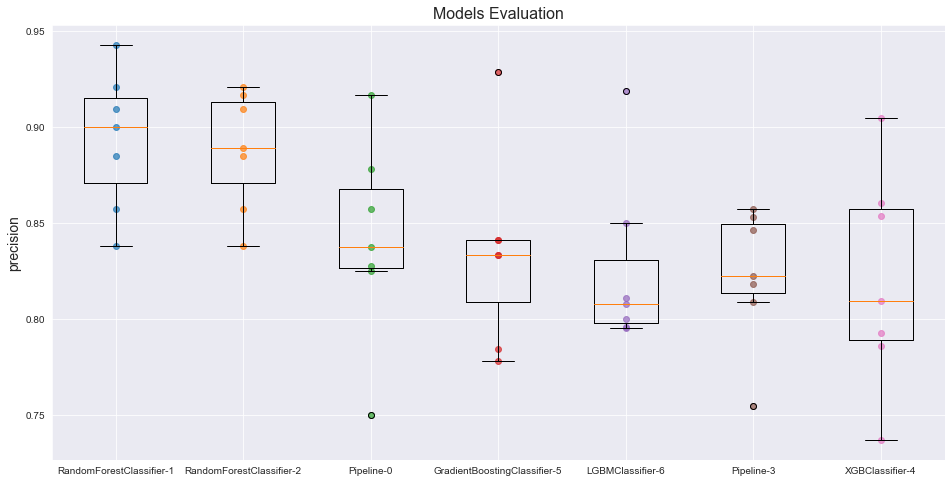

In [123]:
a=ModelsComp(metric='precision')

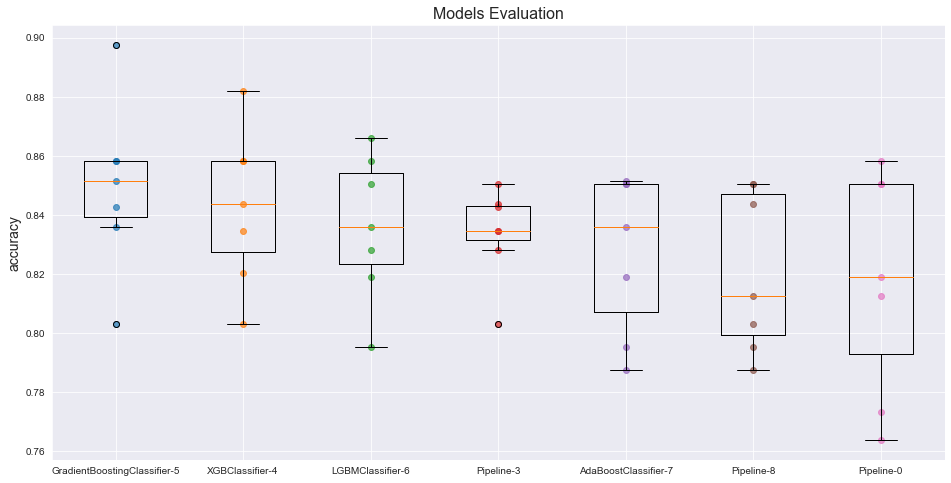

In [124]:
b=ModelsComp(metric='accuracy')

In [125]:
# Accuracy
b 

,MeanScore,Std,0,1,2,3,4,5,6
GradientBoostingClassifier-5,0.849620,0.028449,0.851562,0.835938,0.858268,0.858268,0.897638,0.803150,0.842520
XGBClassifier-4,0.842898,0.026305,0.843750,0.820312,0.834646,0.858268,0.881890,0.803150,0.858268
LGBMClassifier-6,0.836148,0.024578,0.828125,0.835938,0.850394,0.818898,0.858268,0.795276,0.866142
Pipeline-3,0.833890,0.015402,0.843750,0.828125,0.834646,0.834646,0.850394,0.803150,0.842520
AdaBoostClassifier-7,0.827123,0.027135,0.835938,0.851562,0.850394,0.795276,0.818898,0.787402,0.850394
Pipeline-8,0.820409,0.027156,0.812500,0.843750,0.850394,0.803150,0.795276,0.787402,0.850394
Pipeline-0,0.818239,0.038027,0.773438,0.812500,0.850394,0.818898,0.850394,0.763780,0.858268
RandomForestClassifier-1,0.817158,0.036978,0.773438,0.773438,0.818898,0.826772,0.858268,0.803150,0.866142
RandomForestClassifier-2,0.812658,0.038072,0.773438,0.773438,0.818898,0.826772,0.850394,0.779528,0.866142


In [126]:
# Precision
a

,MeanScore,Std,0,1,2,3,4,5,6
RandomForestClassifier-1,0.893228,0.036467,0.884615,0.857143,0.837838,0.909091,0.942857,0.900000,0.921053
RandomForestClassifier-2,0.887899,0.031197,0.884615,0.857143,0.837838,0.909091,0.916667,0.888889,0.921053
Pipeline-0,0.841665,0.051780,0.750000,0.857143,0.837209,0.825000,0.916667,0.827586,0.878049
GradientBoostingClassifier-5,0.834164,0.049446,0.840909,0.833333,0.777778,0.840909,0.928571,0.833333,0.784314
LGBMClassifier-6,0.825542,0.045255,0.800000,0.850000,0.795918,0.795455,0.918919,0.810811,0.807692
Pipeline-3,0.822839,0.035342,0.822222,0.846154,0.754717,0.818182,0.857143,0.852941,0.808511
XGBClassifier-4,0.820488,0.056144,0.853659,0.809524,0.736842,0.860465,0.904762,0.785714,0.792453
AdaBoostClassifier-7,0.791347,0.027191,0.780000,0.826087,0.773585,0.744681,0.809524,0.805556,0.800000
Pipeline-8,0.777131,0.037382,0.735849,0.822222,0.763636,0.750000,0.744681,0.823529,0.800000


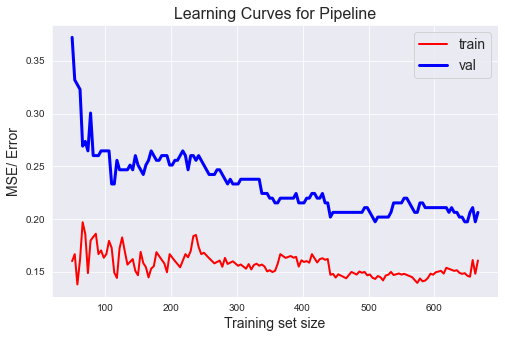

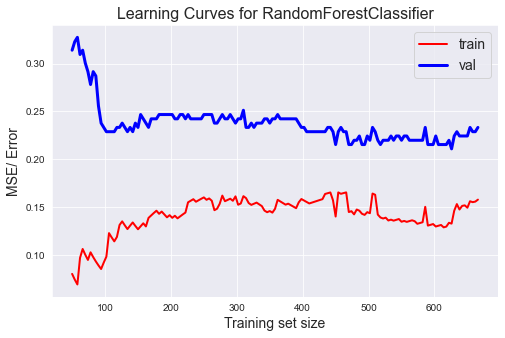

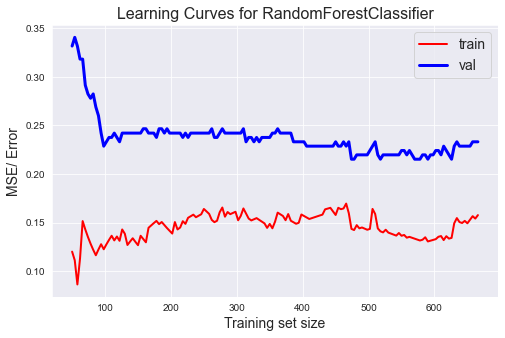

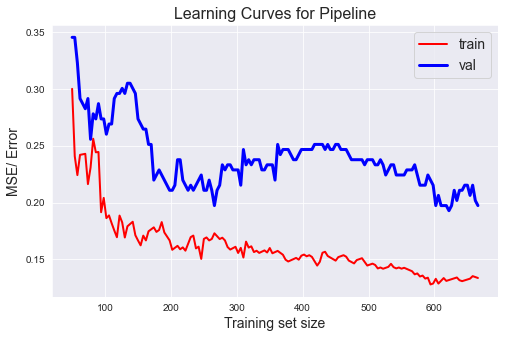

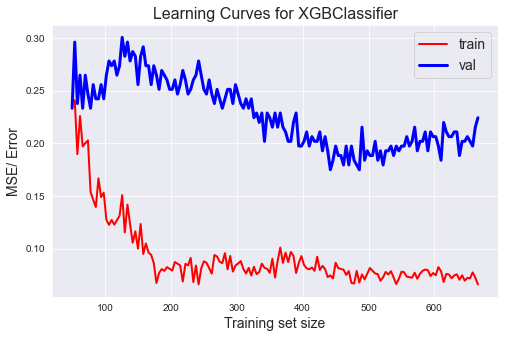

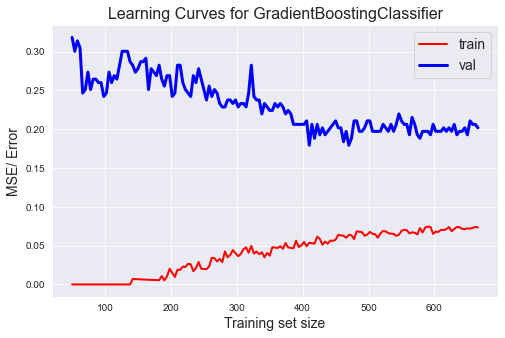

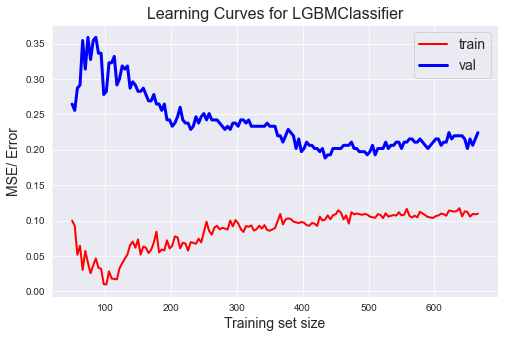

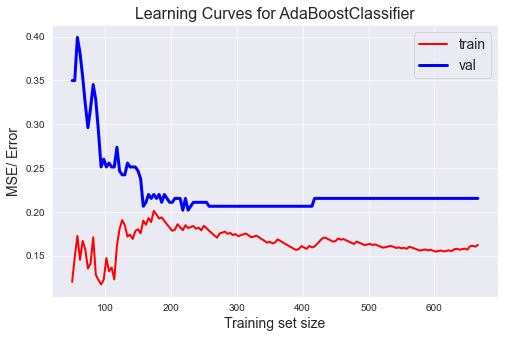

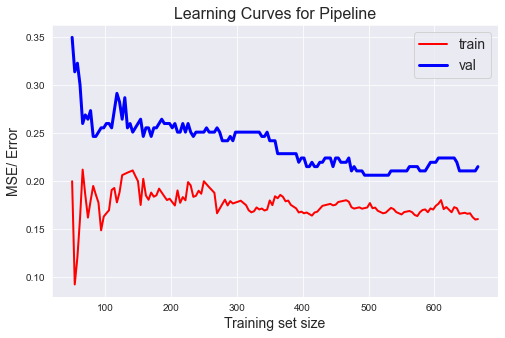

In [842]:
for model in models_list:
    plot_learning_curves(model, m_initial = 50)


## Ensemble methods: Voting of top 3

In [127]:
print(pd.Series(models_list))
models_list

0    (StandardScaler(), LogisticRegression(class_we...
1    RandomForestClassifier(class_weight={0: 6, 1: ...
2    RandomForestClassifier(class_weight={0: 6, 1: ...
3    (StandardScaler(), KNeighborsClassifier(leaf_s...
4    XGBClassifier(base_score=None, booster=None, c...
5    GradientBoostingClassifier(max_depth=4, max_fe...
6    LGBMClassifier(max_depth=4, min_child_samples=...
7                AdaBoostClassifier(learning_rate=0.1)
8       (StandardScaler(), LinearSVC(random_state=42))
dtype: object


[Pipeline(steps=[('standardscaler', StandardScaler()),
                 ('logisticregression',
                  LogisticRegression(class_weight={0: 6, 1: 4}))]),
 RandomForestClassifier(class_weight={0: 6, 1: 4}, max_depth=4,
                        min_samples_leaf=3, n_estimators=1000, random_state=0),
 RandomForestClassifier(class_weight={0: 6, 1: 4}, max_depth=4,
                        min_samples_leaf=2, min_samples_split=3,
                        n_estimators=750, random_state=0),
 Pipeline(steps=[('standardscaler', StandardScaler()),
                 ('kneighborsclassifier',
                  KNeighborsClassifier(leaf_size=6, metric='manhattan',
                                       n_neighbors=7))]),
 XGBClassifier(base_score=None, booster=None, colsample_bylevel=None,
               colsample_bynode=None, colsample_bytree=0.8,
               enable_categorical=False, eta=0.3, eval_metric='error', gamma=0.9,
               gpu_id=None, importance_type=None, interaction_cons

In [850]:
# Choose models to include in the ensemble (numbers)

modelnumbers=[2,3,4]

In [851]:
est=[]

for x in [models_list[j] for j in modelnumbers ]:
        est.append( (x.__class__.__name__ , x) )
        
est

[('RandomForestClassifier',
  RandomForestClassifier(class_weight={0: 6, 1: 4}, max_depth=4,
                         min_samples_leaf=2, min_samples_split=3,
                         n_estimators=750, random_state=0)),
 ('Pipeline',
  Pipeline(steps=[('standardscaler', StandardScaler()),
                  ('kneighborsclassifier',
                   KNeighborsClassifier(leaf_size=6, metric='manhattan',
                                        n_neighbors=7))])),
 ('XGBClassifier',
  XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
                colsample_bynode=1, colsample_bytree=0.8, eta=0.3,
                eval_metric='error', gamma=0.9, gpu_id=-1, importance_type='gain',
                interaction_constraints='', learning_rate=0.300000012,
                max_delta_step=0, max_depth=6, min_child_weight=4, missing=nan,
                monotone_constraints='()', n_estimators=500, n_jobs=8,
                num_parallel_tree=1, random_state=0, reg_alpha=0, reg_la

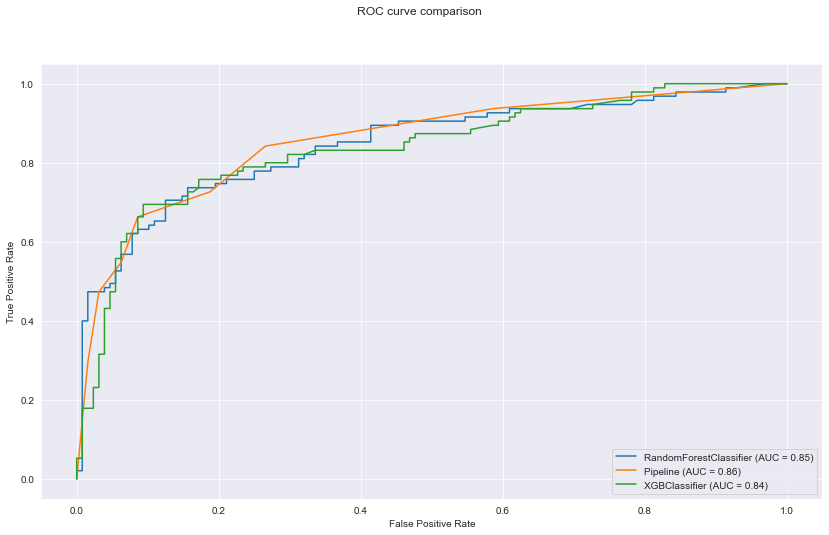

In [852]:
plt.figure(figsize=(14,8))

for model in [models_list[j] for j in modelnumbers ]:
    plot_ROC_curve(model)

In [853]:
# Voting Classifier

vcl=VotingClassifier(voting='hard', estimators=est)
models_list_new=models_list + [vcl]

In [854]:
cross_val_score(vcl, X_train, y_train, cv=7, scoring='accuracy').mean()

0.8507627952755906

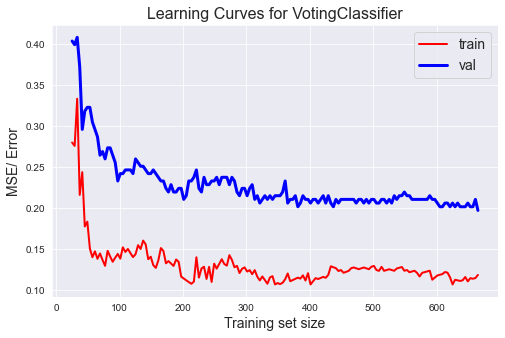

In [855]:
plot_learning_curves(vcl)

# Error Analysis & Submission

In [856]:
# Set the top model
topmodel=rf_clf_best

In [857]:
# Error Analysis I - Confusion Matrix, Precision, Recall

y_pred = cross_val_predict(topmodel, X_train, y_train, cv=10)
print( confusion_matrix(   y_train ,y_pred  ))
print(  precision_score( y_train, y_pred) , recall_score(y_train, y_pred)  )

[[522  27]
 [145 197]]
0.8794642857142857 0.5760233918128655


In [858]:
# Error Analysis II

def error_analysis_inspection(model=topmodel, rs=42, test_size=0.1):
    X_train_ea, X_val_ea, y_train_ea, y_val_ea = train_test_split(X_train, y_train, test_size=test_size, random_state=rs)
    model.fit(X_train_ea, y_train_ea)
    y_val_ea_predict=model.predict(X_val_ea)
    vector_ea= (y_val_ea - y_val_ea_predict).abs()
    accuracy_ea=vector_ea.mean()
    index_ea=vector_ea[vector_ea!=0].index
    
    features_cat_ea=[ x for x in features_cat if x in X_train.columns ]
    try:
        df_ea_0_cat= pd.DataFrame(ohe.inverse_transform(X_val_ea[features_cat][vector_ea!=0]), index=index_ea)
    except:
        df_ea_0_cat=pd.DataFrame(X_val_ea[features_cat_ea][vector_ea!=0], index=index_ea)
    df_ea_0_num=pd.DataFrame(X_val_ea[numerical_cols][vector_ea!=0], index=index_ea)
    df_ea_0=pd.concat([df_ea_0_num, df_ea_0_cat], axis=1)
    y_val_ea_0= pd.DataFrame( y_val_ea[vector_ea!=0] )
    y_val_ea_predict_0 =pd.DataFrame( y_val_ea_predict[vector_ea!=0], index=index_ea, columns=['Predicted'] )

    ea_df=pd.concat([df_ea_0, y_val_ea_0, y_val_ea_predict_0 ], axis=1).sort_values(by=['Survived'])
    print('The accuracy is', 1-accuracy_ea  ) 
    return ea_df
    
ea=error_analysis_inspection(rs=78, test_size=0.5)
ea

The accuracy is 0.820627802690583


,Age,Fare,FamilySize_enc,Pclass_1,Pclass_2,Pclass_3,Embarked_C,Embarked_S,Title_Dr,Title_Master,Title_Miss,Title_Mr,Title_Mrs,Survived,Predicted
18,31,18,0.563,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0,1
617,26,16,0.563,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0,1
111,14,14,0.563,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0,1
852,9,15,0.563,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0,1
799,30,24,0.563,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
429,32,8,0.304,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1,0
430,28,26,0.304,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1,0
484,25,91,0.563,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1,0
32,28,7,0.304,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1,0


In [859]:
train.loc[ea.index, :].T

,18,617,111,852,799,423,657,205,49,251,...,28,376,690,727,261,429,430,484,32,65
PassengerId,19,618,112,853,800,424,658,206,50,252,...,29,377,691,728,262,430,431,485,33,66
Survived,0,0,0,0,0,0,0,0,0,0,...,1,1,1,1,1,1,1,1,1,1
Pclass,3,3,3,3,3,3,3,3,3,3,...,3,3,1,3,3,3,1,1,3,3
Name,"Vander Planke, Mrs. Julius (Emelia Maria Vande...","Lobb, Mrs. William Arthur (Cordelia K Stanlick)","Zabour, Miss. Hileni","Boulos, Miss. Nourelain","Van Impe, Mrs. Jean Baptiste (Rosalie Paula Go...","Danbom, Mrs. Ernst Gilbert (Anna Sigrid Maria ...","Bourke, Mrs. John (Catherine)","Strom, Miss. Telma Matilda","Arnold-Franchi, Mrs. Josef (Josefine Franchi)","Strom, Mrs. Wilhelm (Elna Matilda Persson)",...,"O'Dwyer, Miss. Ellen ""Nellie""","Landergren, Miss. Aurora Adelia","Dick, Mr. Albert Adrian","Mannion, Miss. Margareth","Asplund, Master. Edvin Rojj Felix","Pickard, Mr. Berk (Berk Trembisky)","Bjornstrom-Steffansson, Mr. Mauritz Hakan","Bishop, Mr. Dickinson H","Glynn, Miss. Mary Agatha","Moubarek, Master. Gerios"
Sex,female,female,female,female,female,female,female,female,female,female,...,female,female,male,female,male,male,male,male,female,male
Age,31,26,14.5,9,30,28,32,2,18,29,...,NaN,22,31,NaN,3,32,28,25,NaN,NaN
SibSp,1,1,1,1,1,1,1,0,1,1,...,0,0,1,0,4,0,0,1,0,1
Parch,0,0,0,1,1,1,1,1,0,1,...,0,0,0,0,2,0,0,0,0,1
Ticket,345763,A/5. 3336,2665,2678,345773,347080,364849,347054,349237,347054,...,330959,C 7077,17474,36866,347077,SOTON/O.Q. 392078,110564,11967,335677,2661
Fare,18,16.1,14.4542,15.2458,24.15,14.4,15.5,10.4625,17.8,10.4625,...,7.8792,7.25,57,7.7375,31.3875,8.05,26.55,91.0792,7.75,15.2458


In [860]:
# Get predictions

topmodel.fit(X_train ,y_train)
y_predictions=topmodel.predict(X_test)
submit = pd.DataFrame({'PassengerId': test.PassengerId, 'Survived': y_predictions})
submit.to_csv('submission_fv4.csv', index=False)
print('Your submission was successfully saved!')
print( '\nThe percentages are as follows:' )
print(submit.Survived.value_counts(normalize=True))

Your submission was successfully saved!

The percentages are as follows:
0    0.753589
1    0.246411
Name: Survived, dtype: float64
